In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import sys

utils_path = os.path.dirname(os.path.abspath(__name__)) + '/../utils/'
if utils_path not in sys.path:    
    sys.path.append(utils_path)


from LR_dataset_generator import LR_dataset_generator

import basic_nodes as nodes

# Chapter.9.02 SVLoR for One Sample with Modularization

PA 9.01에서 구현했던 SVLoR for One sample을 modularization을 통해서<br>
구현한다

### Step.1 Affine function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import basic_nodes as nodes

class Affine:
    ### Start
    def __init__(self):
        self._feature_dim = 1
        self._Th = None
        
        self.node_imp()
        self.random_initialization()

    def node_imp(self):
        self._node1 = nodes.mul_node()
        self._node2 = nodes.plus_node()
    
    def random_initialization(self):
        r_feature_dim = 1/np.sqrt(self._feature_dim)
        self._Th = np.random.uniform(low = -1 * r_feature_dim,
                                     high = r_feature_dim,
                                     size = (self._feature_dim + 1,1))
    
    def forward(self,x):
        self._z1 = self._node1.forward(self._Th[1], x)
        self._z2 = self._node2.forward(self._Th[0], self._z1)

        return self._z2
    
    def backward(self, dz, lr):
        dth0, dz1 = self._node2.backward(dz)
        dth1, dx = self._node1.backward(dz1)

        self._Th[1] = self._Th[1] - lr*dth1
        self._Th[0] = self._Th[0] - lr*dth0
    ### End
    def get_Th(self):
        return self._Th 
    

### Step.2 Sigmoid


In [4]:
class Sigmoid:
    def __init__(self):
        self._pred = None
    ### Start
    def forward(self, z):
        self._pred = 1/(1 + np.exp(-1*z))
        return self._pred
    
    def backward(self, dpred):
        partial = self._pred * (1 - self._pred)
        dz = dpred * partial
        return dz
    ### End

### Step.3 BinaryCrossEntropy

In [5]:
class BinaryCrossEntropy_Loss:
    def __init__(self):
        self._y, self._pred = None, None
    ### Start
    def forward(self, y, pred):
        self._y, self._pred = y, pred
        loss = -1*(y*np.log(self._pred) + (1-y)*np.log(1-pred))
        return loss
    
    def backward(self):
        dpred = (self._pred - self._y)/(self._pred*(1-self._pred))
        return dpred
    ### End

### Step.4 SVLoR

In [6]:
class SVLoR:
    def __init__(self):
        self._feature_dim = 1
        self._affine = Affine()
        self._sigmoid = Sigmoid()
    ### Start
    def forward(self, x):
        z = self._affine.forward(x)
        pred =  self._sigmoid.forward(z)
        return pred
    
    def backward(self, dpred, lr):
        dz = self._sigmoid.backward(dpred)
        self._affine.backward(dz, lr)
    ### End
    def  get_Th(self):
        return self._affine.get_Th()

### Step.5 Visualization

In [7]:
def result_tracker():
    global iter_idx, check_freq
    global th_accum, model

    if iter_idx % check_freq == 0:
        th_accum = np.hstack((th_accum, model.get_Th()))
        loss_list.append(loss)
    iter_idx += 1
def result_visualizer():
    global th_accum, loss_list
    fig,ax = plt.subplots(2, 1, figsize = (30,10))
    fig.subplots_adjust(hspace = 0.3)
    ax[0].set_title(r'$\vec{\theta}$' + 'Update ')

    ax[0].plot(th_accum[1,:], label = r'$\theta_{1}$')
    ax[0].plot(th_accum[0,:], label = r'$\theta_{0}$')

    ax[0].legend()
    iter_ticks = np.linspace(0,th_accum.shape[1],10).astype(np.int)
    ax[0].set_xticks(iter_ticks)

    ax[1].set_title(r'$\mathcal{L}$')
    ax[1].plot(loss_list)
    ax[1].set_xticks(iter_ticks)

    n_pred = 1000
    fig,ax = plt.subplots(figsize = (30,10))
    ax.set_title('Predictor Update')
    ax.scatter(data[:,1], data[:,-1])

    ax_idx_arr = np.linspace(0,len(loss_list)-1,n_pred).astype(np.int)
    cmap = cm.get_cmap('rainbow',lut = len(ax_idx_arr))

    x_pred = np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000)
    for ax_cnt, ax_idx in enumerate(ax_idx_arr):
        z = th_accum[1, ax_idx] * x_pred + th_accum[0,ax_idx]
        a = 1/(1 + np.exp(-1 * z))
        ax.plot(x_pred, a, color = cmap(ax_cnt),alpha = 0.2)

    y_ticks = np.round(np.linspace(0, 1, 7),2)
    ax.set_yticks(y_ticks)

### Step.6 Dataset

In [8]:
def dataset_generator(x_dict):
    ### Start
    x_data = np.random.normal(x_dict['mean'], x_dict['std'],x_dict['n_sample'])
    x_data_noise = x_data + x_dict['noise_factor'] * np.random.normal(0,1,x_dict['n_sample'])
    
    if x_dict['direction'] > 0:
        y_data = (x_data_noise > x_dict['cutoff']).astype(np.int)
    else:
        y_data = (x_data_noise < x_dict['cutoff']).astype(np.int)
    
    data = np.zeros(shape = (x_dict['n_sample'],1))
    data = np.hstack((data,x_data.reshape(-1,1),y_data.reshape(-1,1)))
    ### End
    return data

### Step.7
모듈화한 dataset_generator를 통해서 dataset을 생성합니다<br><br>
"""<br>
mean: 1<br>
std: 1<br>
n_sample: 300<br>
noise_factor: 0.3<br>
cutoff: 1<br>
direction: -1<br>
"""<br><br>

In [9]:
x_dict =  {'mean':1, 'std':1, 'n_sample':300,
            'noise_factor':0.3,
            'cutoff':1, 'direction':-1}

data = dataset_generator(x_dict)

### Step.8
model과 BinaryCrossEntropy 객체를 생성합니다<br>
iter_idx: 0으로 초기화하고<br>
check_freq:5로 초기화합니다<br>
epochs는 300 lr은 0.01로 설정합니다

In [10]:
### Start
model =  SVLoR()
BCE_loss = BinaryCrossEntropy_Loss()

th_accum = model.get_Th()

loss_list = []
iter_idx, check_freq = 0, 5
epochs, lr =  300, 0.01
### End

### Step.9 Training

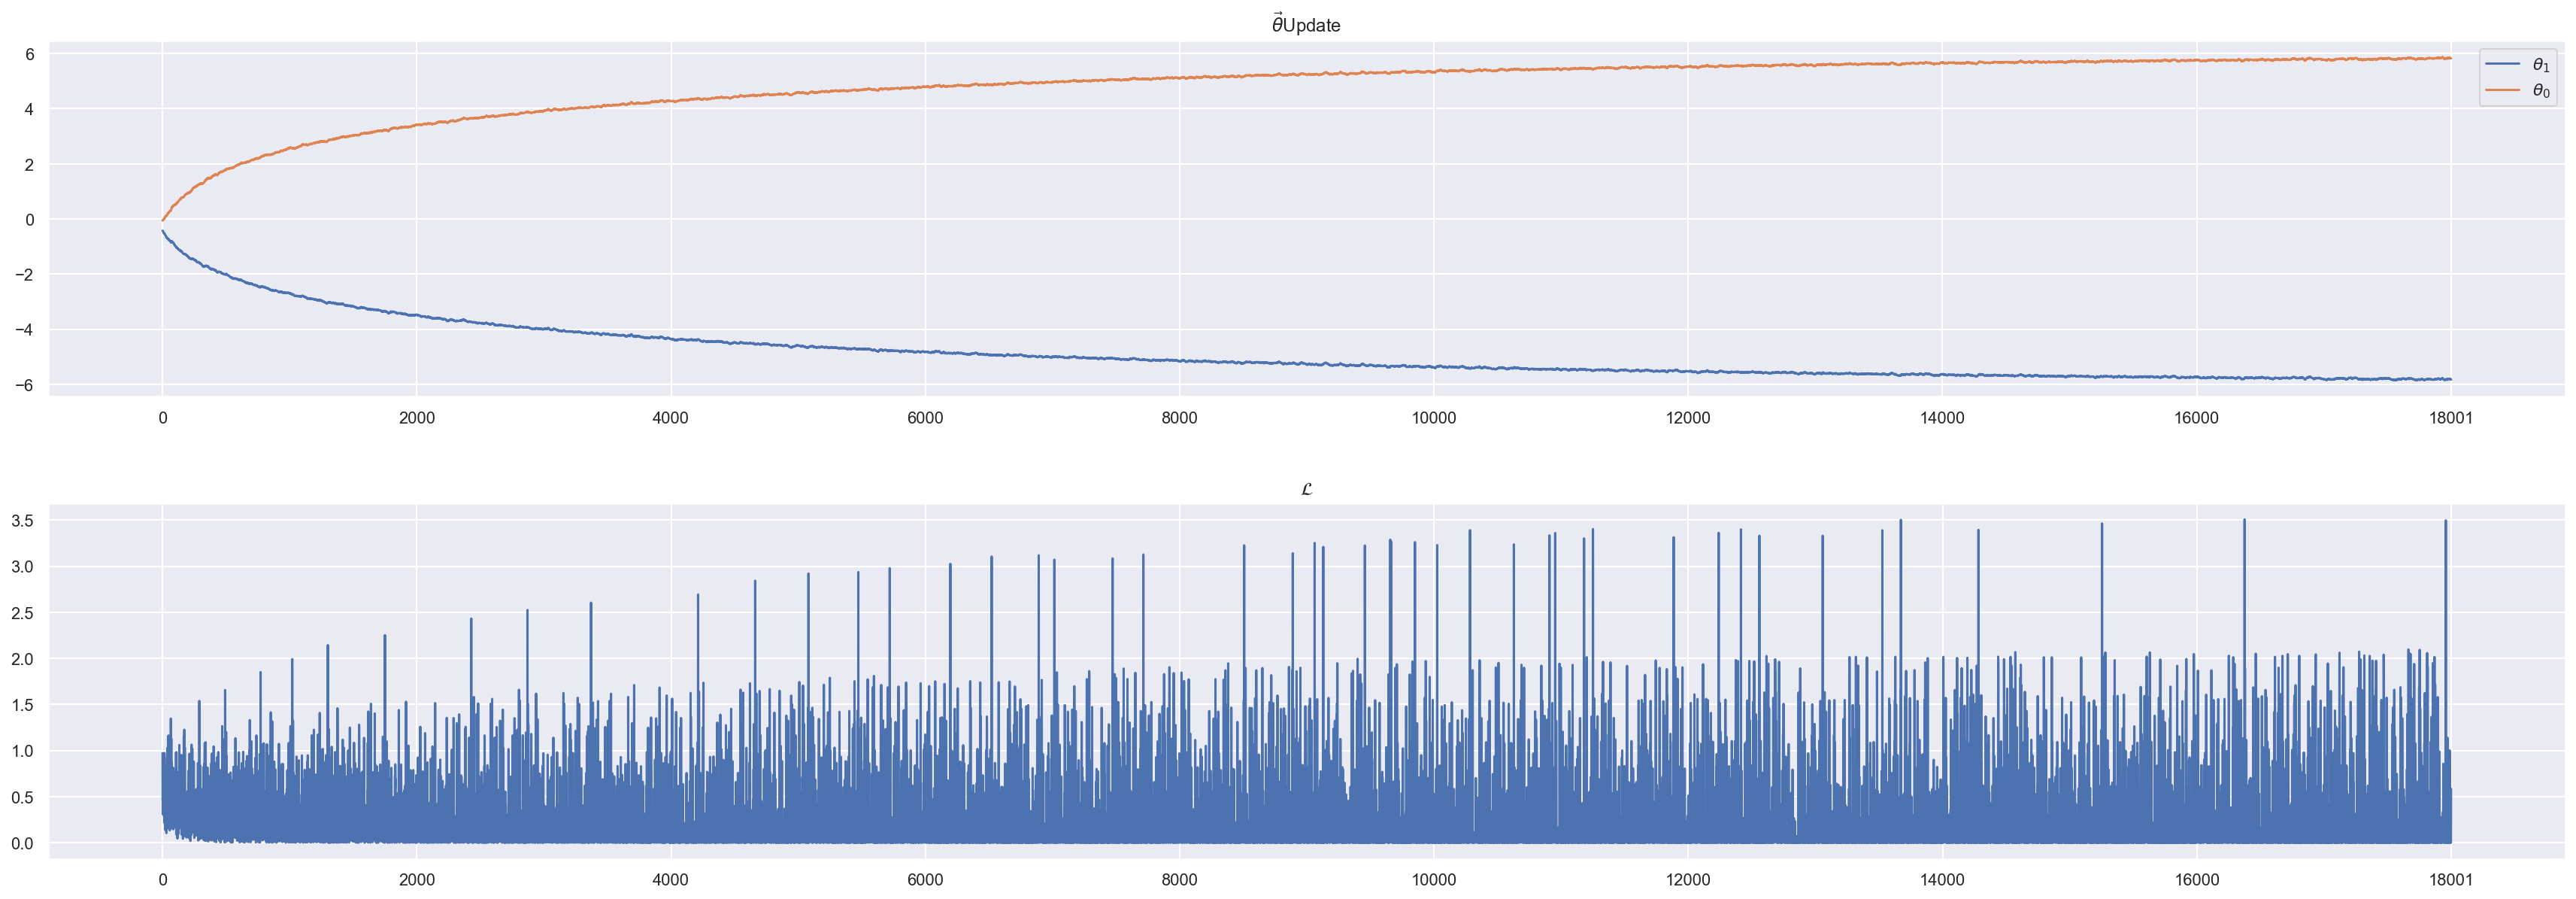

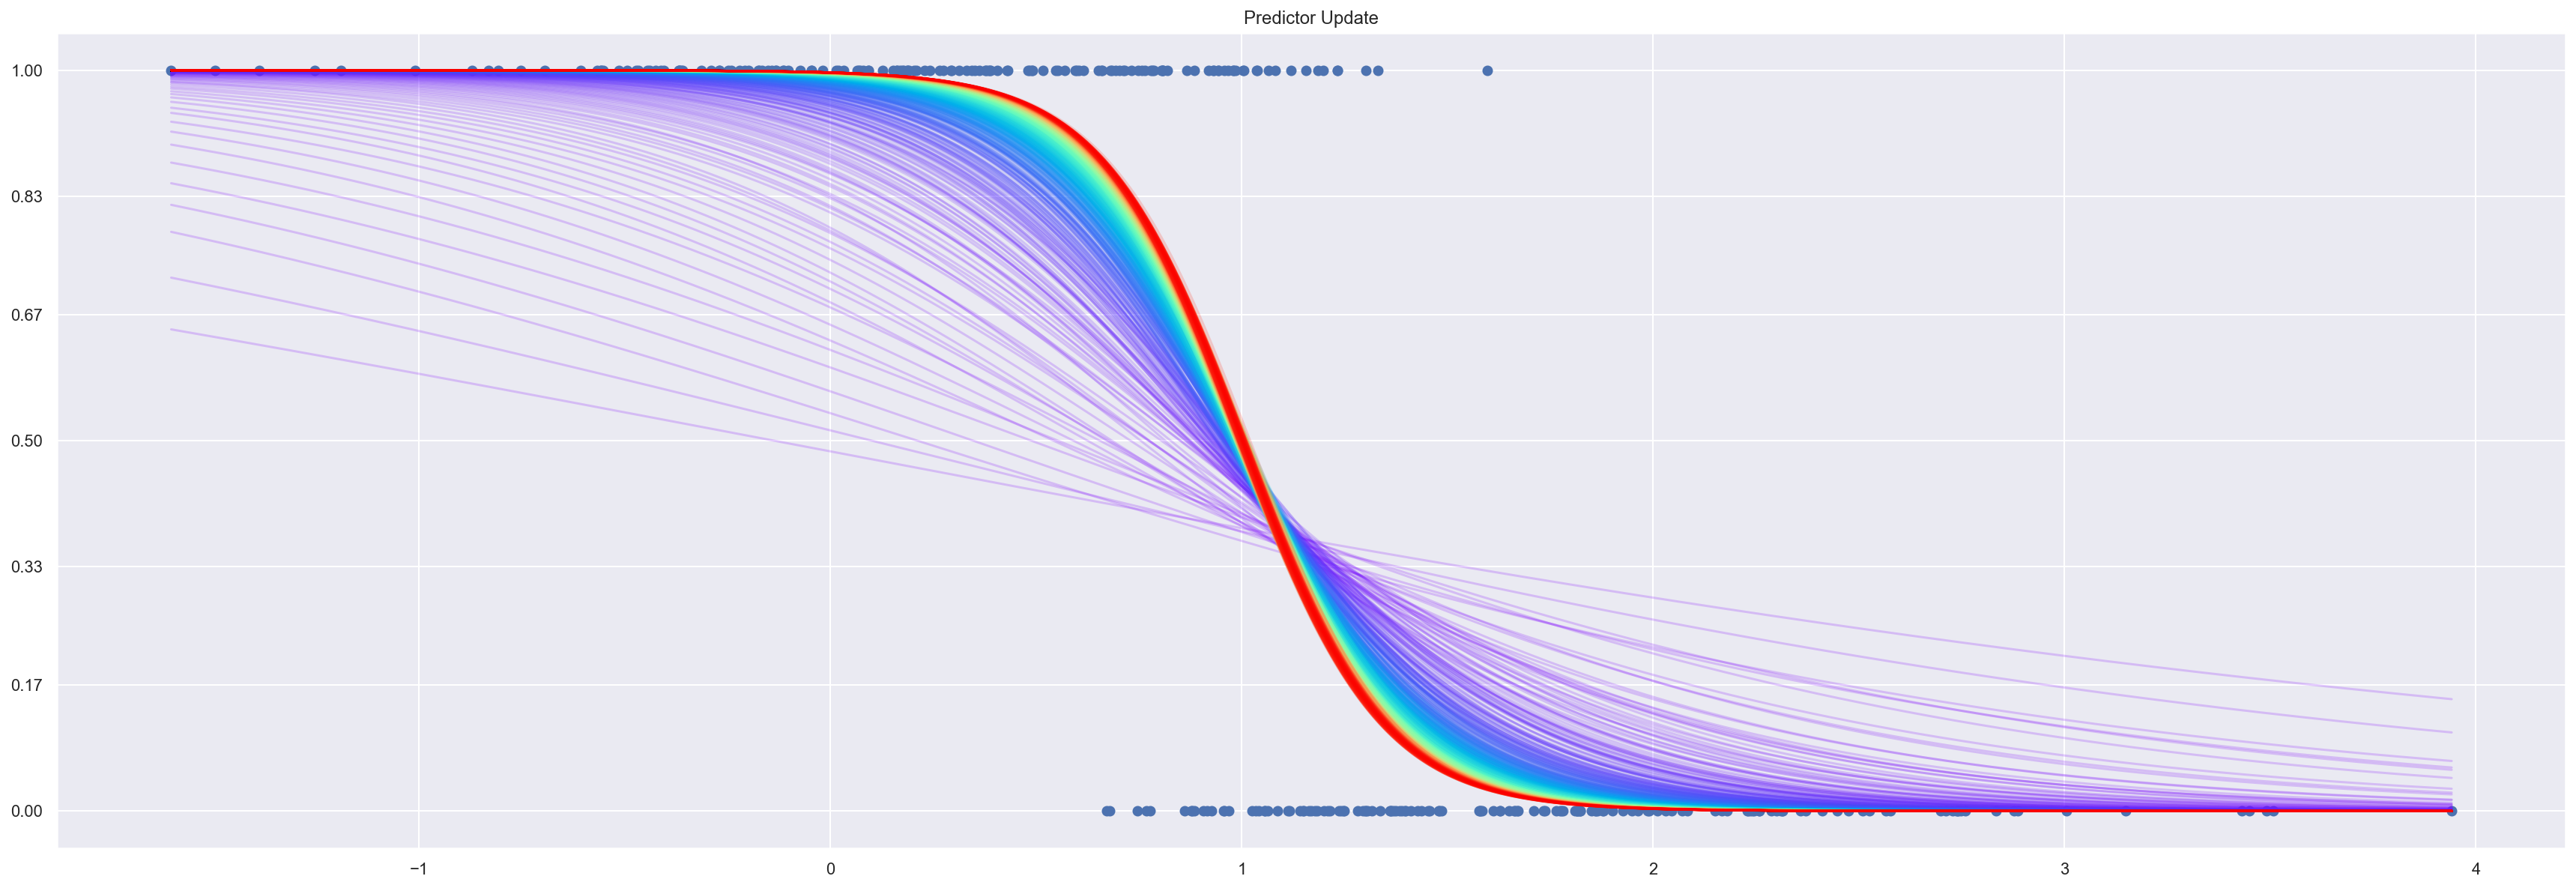

In [11]:
for epoch in range(epochs):
    np.random.shuffle(data)
    
    for data_idx in range(data.shape[0]):
        ### Start
        x,y =  data[data_idx, 1], data[data_idx,-1]

        pred = model.forward(x)
        loss = BCE_loss.forward(y, pred)

        dpred = BCE_loss.backward()
        model.backward(dpred, lr)
        ### End
        result_tracker()
result_visualizer()